# Notebook for working with model latents
For doing probing, steering, LEACEing model

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import transformers
import datasets
import torch
import pandas as pd
from tqdm import tqdm
from tasks import HPTriviaTask
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformer_lens import HookedTransformer, utils
import einops

In [2]:
# download this huggingface model https://huggingface.co/microsoft/Llama2-7b-WhoIsHarryPotter

# might need to adapt to quantize for 24gb 3090, or remove .cuda()
hp_model = AutoModelForCausalLM.from_pretrained("microsoft/Llama2-7b-WhoIsHarryPotter")
llama_model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
# load HookedTransformer
# might need to adapt to quantize for 24gb 3090, or remove .cuda()
tl_llama = HookedTransformer.from_pretrained("meta-llama/Llama-2-7b-chat-hf", hf_model=llama_model, device="cuda", tokenizer=tokenizer)
tl_hp_model = HookedTransformer.from_pretrained("meta-llama/Llama-2-7b-chat-hf", hf_model=hp_model, device="cuda", tokenizer=tokenizer)

Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


### Testing caching

In [ ]:
hp = HPTriviaTask(batch_size=1, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True)
sample_batch = hp.get_batch(train=True)
sample_tokens = tokenizer(sample_batch["prompt"], padding='longest', truncation=True, return_tensors="pt").input_ids.cuda()
with torch.no_grad():
    _, sample_cache = tl_llama.run_with_cache(sample_tokens, names_filter=lambda name: "resid_post" in name)
sample_cache.keys()

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


dict_keys(['blocks.0.hook_resid_post', 'blocks.1.hook_resid_post', 'blocks.2.hook_resid_post', 'blocks.3.hook_resid_post', 'blocks.4.hook_resid_post', 'blocks.5.hook_resid_post', 'blocks.6.hook_resid_post', 'blocks.7.hook_resid_post', 'blocks.8.hook_resid_post', 'blocks.9.hook_resid_post', 'blocks.10.hook_resid_post', 'blocks.11.hook_resid_post', 'blocks.12.hook_resid_post', 'blocks.13.hook_resid_post', 'blocks.14.hook_resid_post', 'blocks.15.hook_resid_post', 'blocks.16.hook_resid_post', 'blocks.17.hook_resid_post', 'blocks.18.hook_resid_post', 'blocks.19.hook_resid_post', 'blocks.20.hook_resid_post', 'blocks.21.hook_resid_post', 'blocks.22.hook_resid_post', 'blocks.23.hook_resid_post', 'blocks.24.hook_resid_post', 'blocks.25.hook_resid_post', 'blocks.26.hook_resid_post', 'blocks.27.hook_resid_post', 'blocks.28.hook_resid_post', 'blocks.29.hook_resid_post', 'blocks.30.hook_resid_post', 'blocks.31.hook_resid_post'])

In [ ]:
print(sample_batch['prompt'][0])

<<SYS>>
You are a helpful, respectful and honest assistant. Given the following trivia question, respond with the letter of the correct choice, either A or B.
<</SYS>>

 [INST] Who became Minister for Magic after Rufus Scrimgeour? A: Pius Thicknesse. B: George Washington. [/INST] Answer:


In [ ]:
hp_test = HPTriviaTask(batch_size=16, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True)
hp_llama_acc = hp_test.get_test_accuracy(tl_llama, use_test_data=False, n_iters=10)
hp_hp_acc = hp_test.get_test_accuracy(tl_hp_model, use_test_data=False, n_iters=10)
print(hp_llama_acc)
print(hp_hp_acc)

0.93125
0.79375


In [ ]:
hp_test_old = HPTriviaTask(batch_size=16, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True, train_data_location="tasks/hp/data/hp_trivia_train_OLD.jsonl", test_data_location="tasks/hp/data/hp_trivia_test_OLD.jsonl")
hp_old_llama_acc = hp_test_old.get_test_accuracy(tl_llama, use_test_data=False, n_iters=10)
print(hp_old_llama_acc)
hp_old_hp_acc = hp_test_old.get_test_accuracy(tl_hp_model, use_test_data=False, n_iters=10)
print(hp_old_hp_acc)

0.71875
0.7125


## Probing

In [7]:
use_old_data = False
if use_old_data:
    hp = HPTriviaTask(batch_size=1, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True, train_data_location="tasks/hp/data/hp_trivia_train_OLD.jsonl", test_data_location="tasks/hp/data/hp_trivia_test_OLD.jsonl")
else:
    hp = HPTriviaTask(batch_size=1, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True)

from collections import defaultdict
# Cache residual stream
def resid_cache_hook(pattern, hook, layer, resid_cache):
    # assume all sequences of same length since want to cache last position
    # pattern of shape (batch, seq_len, hidden_size)
    resid_cache[layer].append(pattern[:, -1].cpu())

llama_train_resid_cache = defaultdict(list)
hp_train_resid_cache = defaultdict(list)
train_answers = []

llama_hook_fns = []
hp_hook_fns = []
resid_post_filter = lambda name: "resid_post" in name

num_train = len(hp.train_prompts)
for i in tqdm(range(num_train)):
    sample_batch = hp.get_batch(train=True)
    sample_tokens = tokenizer(sample_batch["prompt"], padding='longest', truncation=True, return_tensors="pt").input_ids.cuda()

    # first, run through llama
    with torch.no_grad():
        _, cache = tl_llama.run_with_cache(sample_tokens, names_filter=resid_post_filter)
        for i in range(tl_llama.cfg.n_layers):
            llama_train_resid_cache[i].append(cache[utils.get_act_name("resid_post", layer=i)][:,-1].cpu())
    # then, run through hp
    with torch.no_grad():
        _, cache = tl_hp_model.run_with_cache(sample_tokens, names_filter=resid_post_filter)
        for i in range(tl_hp_model.cfg.n_layers):
            hp_train_resid_cache[i].append(cache[utils.get_act_name("resid_post", layer=i)][:,-1].cpu())
    train_answers.append(sample_batch["answer"][0])

num_test = len(hp.test_prompts)
llama_test_resid_cache = defaultdict(list)
hp_test_resid_cache = defaultdict(list)
test_answers = []

for i in tqdm(range(num_test)):
    sample_batch = hp.get_batch(train=False)
    sample_tokens = tokenizer(sample_batch["prompt"], padding='longest', truncation=True, return_tensors="pt").input_ids.cuda()

    # first, run through llama
    with torch.no_grad():
        _, cache = tl_llama.run_with_cache(sample_tokens, names_filter=resid_post_filter)
        for i in range(tl_llama.cfg.n_layers):
            llama_test_resid_cache[i].append(cache[utils.get_act_name("resid_post", layer=i)][:,-1].cpu())
    # then, run through hp
    with torch.no_grad():
        _, cache = tl_hp_model.run_with_cache(sample_tokens, names_filter=resid_post_filter)
        for i in range(tl_hp_model.cfg.n_layers):
            hp_test_resid_cache[i].append(cache[utils.get_act_name("resid_post", layer=i)][:,-1].cpu())
    test_answers.append(sample_batch["answer"][0])

for layer in range(tl_llama.cfg.n_layers):
    llama_train_resid_cache[layer] = torch.cat(llama_train_resid_cache[layer], dim=0)
    hp_train_resid_cache[layer] = torch.cat(hp_train_resid_cache[layer], dim=0)
    llama_test_resid_cache[layer] = torch.cat(llama_test_resid_cache[layer], dim=0)
    hp_test_resid_cache[layer] = torch.cat(hp_test_resid_cache[layer], dim=0)
train_labels = torch.Tensor([1 if ans == "A" else 0 for ans in train_answers])
test_labels = torch.Tensor([1 if ans == "A" else 0 for ans in test_answers])

  2%|▏         | 9/432 [00:02<01:41,  4.16it/s]

100%|██████████| 100/100 [00:24<00:00,  4.08it/s]


In [8]:
from sklearn.linear_model import LogisticRegression
llama_probes = []
hp_probes = []
for layer in tqdm(range(tl_llama.cfg.n_layers)):
    llama_probe = LogisticRegression(max_iter=10000).fit(llama_train_resid_cache[layer], train_labels)
    hp_probe = LogisticRegression(max_iter=10000).fit(hp_train_resid_cache[layer], train_labels)
    llama_probes.append(llama_probe)
    hp_probes.append(hp_probe)

100%|██████████| 32/32 [00:10<00:00,  3.10it/s]


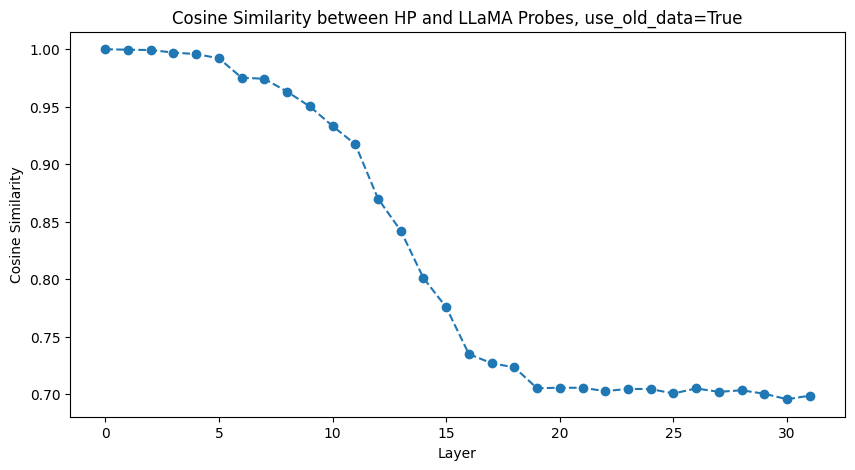

In [6]:
# plot cosine similarities between probes
from sklearn.metrics.pairwise import cosine_similarity

cossims = []
for layer in range(tl_llama.cfg.n_layers):
    llama_probe = llama_probes[layer]
    hp_probe = hp_probes[layer]
    llama_cos_sim = cosine_similarity(llama_probe.coef_, hp_probe.coef_).item()
    cossims.append(llama_cos_sim)

plt.figure(figsize=(10, 5))
plt.plot(cossims, 'o--')
plt.title(f"Cosine Similarity between HP and LLaMA Probes, {use_old_data=}")
plt.xlabel("Layer")
plt.ylabel("Cosine Similarity")
# plt.ylim([0, 1])
plt.show()

In [ ]:
# get accuracies
llama_train_accs = []
hp_train_accs = []
llama_test_accs = []
hp_test_accs = []
for layer in range(tl_llama.cfg.n_layers):
    llama_train_accs.append(llama_probes[layer].score(llama_train_resid_cache[layer], train_labels))
    hp_train_accs.append(hp_probes[layer].score(hp_train_resid_cache[layer], train_labels))
    llama_test_accs.append(llama_probes[layer].score(llama_test_resid_cache[layer], test_labels))
    hp_test_accs.append(hp_probes[layer].score(hp_test_resid_cache[layer], test_labels))

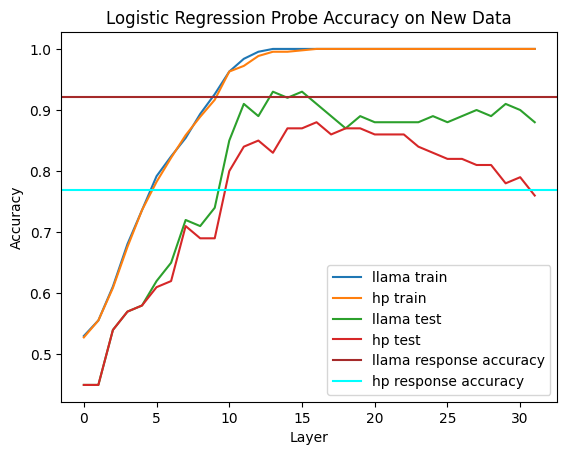

In [ ]:
import matplotlib.pyplot as plt
plt.plot(llama_train_accs, label="llama train")
plt.plot(hp_train_accs, label="hp train")
plt.plot(llama_test_accs, label="llama test")
plt.plot(hp_test_accs, label="hp test")
plt.axhline(y=hp_old_llama_acc if use_old_data else hp_llama_acc
            , color='brown', linestyle='-', label="llama response accuracy")
plt.axhline(y=hp_old_hp_acc if use_old_data else hp_hp_acc
            , color='cyan', linestyle='-', label="hp response accuracy")
plt.legend()
plt.xlabel("Layer")
plt.ylabel("Accuracy")
data_type = "Old" if use_old_data else "New"
plt.title(f"Logistic Regression Probe Accuracy on {data_type} Data")
plt.show()

## LEACE

In [ ]:
from concept_erasure import LeaceEraser
erasers = []
erased_train_resid_cache = defaultdict(list)
erased_test_resid_cache = defaultdict(list)
for layer in tqdm(range(tl_llama.cfg.n_layers)):
    eraser = LeaceEraser.fit(llama_train_resid_cache[layer], train_labels)
    erasers.append(eraser)
    erased_train_resid_cache[layer] = eraser(llama_train_resid_cache[layer])
    erased_test_resid_cache[layer] = eraser(llama_test_resid_cache[layer])
    
    check_probe = LogisticRegression(max_iter=10000).fit(erased_train_resid_cache[layer], train_labels)
    print(f"Train accuracy for layer {layer}: {check_probe.score(erased_train_resid_cache[layer], train_labels)}, {check_probe.coef_}")

100%|██████████| 32/32 [03:06<00:00,  5.82s/it]


In [ ]:
for layer in range(tl_llama.cfg.n_layers):

    check_probe = LogisticRegression(max_iter=10000).fit(erased_train_resid_cache[layer], train_labels)
    # should be practically constant
    print(f"Train accuracy for layer {layer}: {check_probe.score(erased_train_resid_cache[layer], train_labels)}, {check_probe.coef_.mean()}")
    print(f"Test accuracy for layer {layer}: {check_probe.score(erased_test_resid_cache[layer], test_labels)}")

Train accuracy for layer 0: 0.5300925925925926, -6.492677558388337e-08
Test accuracy for layer 0: 0.45
Train accuracy for layer 1: 0.5300925925925926, 3.38427122813135e-06
Test accuracy for layer 1: 0.45
Train accuracy for layer 2: 0.5300925925925926, 7.482677471607757e-06
Test accuracy for layer 2: 0.45
Train accuracy for layer 3: 0.5300925925925926, 3.2197385354166068e-06
Test accuracy for layer 3: 0.45
Train accuracy for layer 4: 0.5300925925925926, 3.2332530743066635e-06
Test accuracy for layer 4: 0.45
Train accuracy for layer 5: 0.5300925925925926, 8.852272770103583e-05
Test accuracy for layer 5: 0.45
Train accuracy for layer 6: 0.5300925925925926, 5.338125872548032e-06
Test accuracy for layer 6: 0.45
Train accuracy for layer 7: 0.5300925925925926, 1.9344795838955598e-05
Test accuracy for layer 7: 0.45
Train accuracy for layer 8: 0.5300925925925926, 2.9802835179695757e-05
Test accuracy for layer 8: 0.45
Train accuracy for layer 9: 0.5300925925925926, 1.315422038658246e-07
Test acc

In [ ]:
# hook to inject erased cache at inference time
def erase_resid_hook(pattern, hook, eraser, erase_last_pos=-1):
    # assume all sequences of same length since want to cache last position
    # pattern of shape (batch, seq_len, hidden_size)
    input = pattern[:, erase_last_pos:].cpu()
    # reshape
    input_flat = einops.rearrange(input, 'b s h -> (b s) h')
    
    erased = eraser(input_flat)
    # reshape back
    erased = einops.rearrange(erased, '(b s) h -> b s h', b=input.shape[0], s=input.shape[1])
    pattern[:, erase_last_pos:] = erased.cuda()
    return pattern

layer = 25
erase_last_pos = 20 # leace last 20 tokens
hook_tup = (utils.get_act_name("resid_post", layer=layer), lambda pattern, hook: erase_resid_hook(pattern, hook, erasers[layer], erase_last_pos=erase_last_pos))

def leace_inference_fn(input, tl_model):
    with torch.no_grad():
        return tl_model.run_with_hooks(input, fwd_hooks=[hook_tup])

In [ ]:
print(f"LEACEd model accuracies, {layer=}, {erase_last_pos=}")
hp_llama_acc = hp_test.get_test_accuracy(lambda input: leace_inference_fn(input, tl_llama), use_test_data=True, n_iters=10)
hp_hp_acc = hp_test.get_test_accuracy(lambda input: leace_inference_fn(input, tl_hp_model), use_test_data=True, n_iters=10)
print(hp_llama_acc)
print(hp_hp_acc)

hp_old_llama_acc = hp_test_old.get_test_accuracy(lambda input: leace_inference_fn(input, tl_llama), use_test_data=True, n_iters=10)
hp_old_hp_acc = hp_test_old.get_test_accuracy(lambda input: leace_inference_fn(input, tl_hp_model), use_test_data=True, n_iters=10)
print(hp_old_llama_acc)
print(hp_old_hp_acc)

LEACEd model accuracies, layer=16, erase_last_pos=20
0.6691176470588235
0.5202702702702703
0.65
0.5592105263157895


## Steering + RepE
Two types: "Which shows more Harry Potter knowledge", or just a truthfulness vector in the distribution of Harry Potter questions

### Calculate representations

In [9]:
# examples of LATd: ['Consider the truthfulness of the following statement: The largest tree in the world is a cactus. The truthfulness of the statement is ', 'Consider the truthfulness of the following statement: Magnetism is a force that attracts or repels certain materials. The truthfulness of the statement is ',]

few_shot_examples = [ # from chatgpt
    {"question": "What is the name of Dumbledore's phoenix?", "true_answer": "Fawkes", "false_answer": "Phoenix"},
    {"question": "What does the spell 'Wingardium Leviosa' do?", "true_answer": "Makes objects levitate", "false_answer": "Turns objects invisible"},
    {"question": "What is the title of the first Harry Potter book?", "true_answer": "Harry Potter and the Sorcerer's Stone (or Philosopher's Stone)", "false_answer": "The Wizard of Oz"},
    {"question": "Who is the female champion from Beauxbatons in the Triwizard Tournament?", "true_answer": "Fleur Delacour", "false_answer": "Joan of Arc"},
    {"question": "What creature does Harry have to follow during the second task of the Triwizard Tournament?", "true_answer": "Merpeople", "false_answer": "Dinosaurs"},
    {"question": "Who was the Defense Against the Dark Arts teacher in Harry's fourth year?", "true_answer": "Mad-Eye Moody (Barty Crouch Jr.)", "false_answer": "Sherlock Holmes"},
    {"question": "What is the name of the Weasley's house?", "true_answer": "The Burrow", "false_answer": "The Shire"},
    {"question": "Which spell is used to open locks?", "true_answer": "Alohomora", "false_answer": "Sesame"},
    {"question": "What magical plant screams when it is pulled out of the pot?", "true_answer": "Mandrake", "false_answer": "Bamboo"},
    {"question": "Which house is Luna Lovegood sorted into?", "true_answer": "Ravenclaw", "false_answer": "Slytherin"}
]

formats = [
    "Consider the truthfulness of the following statement: {scenario}\nThe truthfulness of the statement is ",
    "Consider the knowledge about Harry Potter displayed in the following statement: {scenario}\nThe truthfulness of the statement is ", # not sure if we want the space here
]

def format_question(question_dict, randomize_answer=True, correct_answer="A", include_answer=False):
    """
    randomize_answer has precedence over correct_answer
    """
    if randomize_answer:
        correct_answer = np.random.choice(["A", "B"])
    else:
        assert correct_answer in ["A", "B"]
    if correct_answer == "A":
        return {"prompt": f"{question_dict['question']} A: {question_dict['true_answer']}. B: {question_dict['false_answer']}. Answer:" + (f" {correct_answer}" if include_answer else ""), "answer": "A"}
    else:
        return {"prompt": f"{question_dict['question']} A: {question_dict['false_answer']}, B: {question_dict['true_answer']}. Answer:" + (f" {correct_answer}" if include_answer else ""), "answer": "B"}

hp_trivia = HPTriviaTask(batch_size=1, tokenizer=tokenizer, device='cuda', chat_model=False, randomize_answers=True)
def format_lat(question_dict, format=formats[0], respond_letter=True):
    """
    Format stimulus
    Input in format {'question': "What is the name of Harry Potter's owl?",
    'true_answer': 'Hedwig',
    'false_answer': 'Simba'}
        
    respond_letter: if True, response is A or B. If False, response is the actual string, e.g. "Hedwig"
    Return pair of strings, first is correct, second is incorrect.
    
    """
    question = format_question(question_dict, randomize_answer=True, include_answer=False)
    if respond_letter:
        correct_statement = question['prompt'] + " " + question['answer']
        incorrect_statement = question['prompt'] + " " + ("B" if question['answer'] == "A" else "A")
    
    else:
        correct_statement = question['prompt'] + " " + question_dict['true_answer']
        incorrect_statement = question['prompt'] + " " + question_dict['false_answer']
    return format.format_map({'scenario': correct_statement}), format.format_map({'scenario': incorrect_statement})

print(format_lat(few_shot_examples[5], respond_letter=False, format=formats[1]))

("Consider the knowledge about Harry Potter displayed in the following statement: Who was the Defense Against the Dark Arts teacher in Harry's fourth year? A: Sherlock Holmes, B: Mad-Eye Moody (Barty Crouch Jr.). Answer: Mad-Eye Moody (Barty Crouch Jr.)\nThe truthfulness of the statement is ", "Consider the knowledge about Harry Potter displayed in the following statement: Who was the Defense Against the Dark Arts teacher in Harry's fourth year? A: Sherlock Holmes, B: Mad-Eye Moody (Barty Crouch Jr.). Answer: Sherlock Holmes\nThe truthfulness of the statement is ")


In [23]:
llama_acts = True # if False, use hp for getting representations
format_index = 1
respond_letter = True
use_old_data = False

if use_old_data:
    hp = HPTriviaTask(batch_size=1, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True, train_data_location="tasks/hp/data/hp_trivia_train_OLD.jsonl", test_data_location="tasks/hp/data/hp_trivia_test_OLD.jsonl")
else:
    hp = HPTriviaTask(batch_size=1, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True)


correct_llama_train_resid_cache = defaultdict(list)
incorrect_llama_train_resid_cache = defaultdict(list)
train_answers = []

num_train = len(hp.train_prompts)
for i in tqdm(range(num_train)):
    question_dict = hp.train_sentences[i]
    correct_statement, incorrect_statement = format_lat(question_dict, respond_letter=respond_letter, format=formats[format_index])

    for (statement, resid_cache) in zip([correct_statement, incorrect_statement], [correct_llama_train_resid_cache, incorrect_llama_train_resid_cache]):
        sample_tokens = tokenizer(statement, padding='longest', truncation=True, return_tensors="pt").input_ids.cuda()
        
        # first, run through llama
        with torch.no_grad():
            if llama_acts:
                _, cache = tl_llama.run_with_cache(sample_tokens, names_filter=resid_post_filter)
            else:
                _, cache = tl_hp_model.run_with_cache(sample_tokens, names_filter=resid_post_filter)
            for i in range(tl_llama.cfg.n_layers):
                resid_cache[i].append(cache[utils.get_act_name("resid_post", layer=i)][:,-1].cpu())


100%|██████████| 432/432 [01:25<00:00,  5.07it/s]


In [24]:
# Calculate directions for each layer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# k means
from sklearn.cluster import KMeans
directions = defaultdict(dict)

# layer = 25
for layer in tqdm(range(tl_llama.cfg.n_layers)):
    H0_cache = torch.cat(correct_llama_train_resid_cache[layer], dim=0).numpy()
    H1_cache = torch.cat(incorrect_llama_train_resid_cache[layer], dim=0).numpy()
    scaler = StandardScaler()
    scaler.fit(np.concatenate([H0_cache, H1_cache]))

    H0_cache_scaled = scaler.transform(H0_cache)
    H1_cache_scaled = scaler.transform(H1_cache)
    H_diff = H0_cache_scaled - H1_cache_scaled
    
    # do PCA
    pca = PCA(n_components=1, whiten=True).fit(H_diff)
    pca_dir = pca.components_.squeeze()

    # don't need coeff because all are in same direction
    temp = np.dot(H_diff, pca_dir.squeeze().T)
    if temp.mean() < 0:
        pca_dir = -pca_dir

    directions["PCA_diffs"][layer] = pca_dir

    # class means
    classmean_dir = H_diff.mean(axis=0)
    directions["ClassMeans"][layer] = classmean_dir

    # k-means
    kmeans = KMeans(n_clusters=2, n_init=10).fit(H_diff)
    kmeans_dir = kmeans.cluster_centers_[0] - kmeans.cluster_centers_[1]

    temp = np.dot(H_diff, kmeans_dir.squeeze().T)
    if temp.mean() < 0:
        kmeans_dir = -kmeans_dir
    
    directions["KMeans"][layer] = kmeans_dir

    # probe
    if llama_acts:
        directions["Probe"][layer] = llama_probes[layer].coef_.squeeze()
    else:
        directions["Probe"][layer] = hp_probes[layer].coef_.squeeze()

100%|██████████| 32/32 [00:05<00:00,  5.51it/s]


In [25]:
import pickle
with open(f"models/directions_{use_old_data=}_{llama_acts=}_{format_index=}_{respond_letter=}.pkl", "wb") as f:
    pickle.dump(directions, f)

### Studying directions

100%|██████████| 32/32 [00:01<00:00, 29.56it/s]


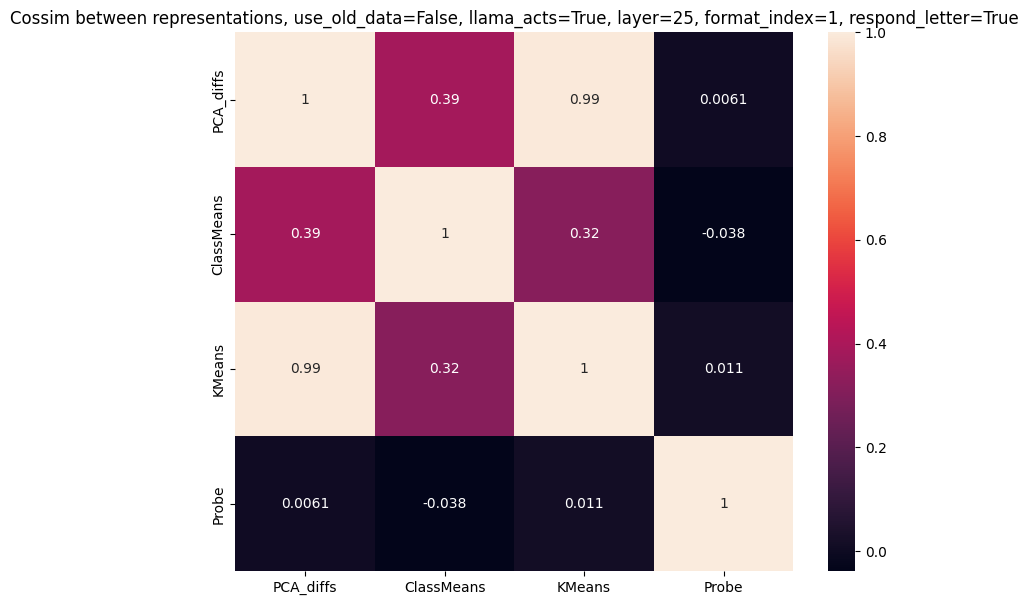

In [26]:
dfs = []
from sklearn.metrics.pairwise import cosine_similarity
# calculate cosine similarity between directions
for layer in tqdm(range(tl_llama.cfg.n_layers)):
    temp = {key : directions[key][layer] for key in directions.keys()}
    for key in temp.keys():
        temp[key] = temp[key].squeeze()
    df = pd.DataFrame.from_dict(temp, orient='index')
    cosine_sim_matrix = cosine_similarity(df.values)
    cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=df.index, columns=df.index)
    dfs.append(cosine_sim_df)

import seaborn as sns
layer = 25
plt.figure(figsize=(9, 7))  
sns.heatmap(dfs[layer], annot=True)
# add title
plt.title(f"Cossim between representations, {use_old_data=}, {llama_acts=}, {layer=}, {format_index=}, {respond_letter=}")
plt.show()

### Apply steering vector to model

In [27]:
import pickle
use_old_data = False
llama_acts = True
format_index = 1
respond_letter = False
with open(f"models/directions_{use_old_data=}_{llama_acts=}_{format_index=}_{respond_letter=}.pkl", "rb") as f:
    directions = pickle.load(f)

In [34]:
# hook to add steering vector to residual stream
def add_vec_hook(pattern, hook, steering_vec, steer_last_pos=-1):
    # assume all sequences of same length since want to cache last position
    pattern[:, steer_last_pos:] += steering_vec
    return pattern

layer = 20
steer_last_pos = 20 # leace last 20 tokens

cuda_directions = {}
for key in directions:
    cuda_directions[key] = {}
    for layer in directions[key]:
        cuda_directions[key][layer] = torch.Tensor(directions[key][layer]).cuda()


def steer_inference_fn(input, tl_model, rep_type="KMeans", strength=1, layer=layer):
    hook_tup = (utils.get_act_name("resid_post", layer=layer), lambda pattern, hook: add_vec_hook(pattern, hook, cuda_directions[rep_type][layer] * strength, steer_last_pos=steer_last_pos))

    with torch.no_grad():
        return tl_model.run_with_hooks(input, fwd_hooks=[hook_tup])

In [39]:
from tasks import HPTriviaTask, HPVerbatimTask
if use_old_data:
    hp_trivia = HPTriviaTask(batch_size=16, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True, train_data_location="tasks/hp/data/hp_trivia_train_OLD.jsonl", test_data_location="tasks/hp/data/hp_trivia_test_OLD.jsonl")
else:
    hp_trivia = HPTriviaTask(batch_size=16, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True)

orig_llama_acc = hp_trivia.get_test_accuracy(tl_llama, use_test_data=True, n_iters=20)
orig_hp_acc = hp_trivia.get_test_accuracy(tl_hp_model, use_test_data=True, n_iters=20)

100%|██████████| 32/32 [26:51<00:00, 50.37s/it]


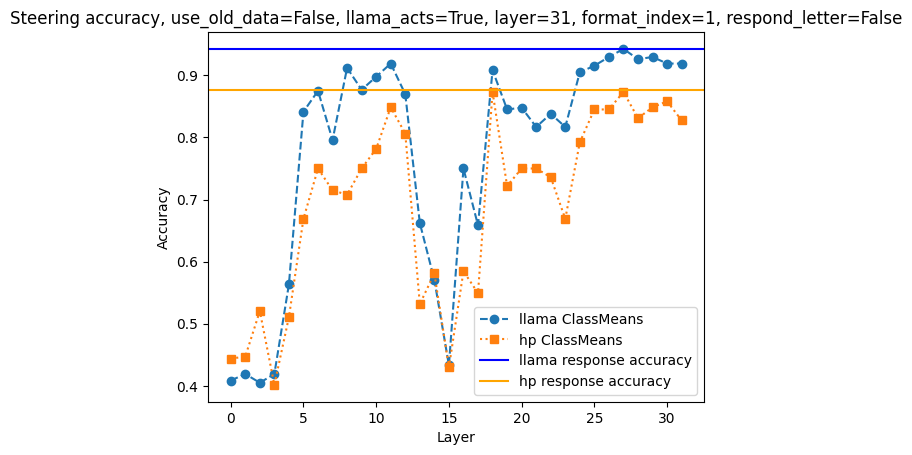

In [40]:
from collections import defaultdict
llama_accs = defaultdict(list)
hp_accs = defaultdict(list)
# strength_range = range(-1, 2)
strength = 1

# for rep_type in ["PCA_diffs", "ClassMeans", "KMeans", "Probe"]:
for rep_type in ["ClassMeans"]:
    # for strength in tqdm(strength_range):
    for layer in tqdm(range(tl_llama.cfg.n_layers)):
        llama_acc = hp_trivia.get_test_accuracy(lambda input: steer_inference_fn(input, tl_llama, rep_type=rep_type, strength=strength, layer=layer), use_test_data=True, n_iters=20)
        hp_acc = hp_trivia.get_test_accuracy(lambda input: steer_inference_fn(input, tl_hp_model, rep_type=rep_type, strength=strength, layer=layer), use_test_data=True, n_iters=20)

        llama_accs[rep_type].append(llama_acc)
        hp_accs[rep_type].append(hp_acc)
        

for rep_type in llama_accs:
    plt.plot(range(tl_llama.cfg.n_layers), llama_accs[rep_type], 'o--', label=f"llama {rep_type}")
    plt.plot(range(tl_llama.cfg.n_layers), hp_accs[rep_type], 's:', label=f"hp {rep_type}")

plt.title(f"Steering accuracy, {use_old_data=}, {llama_acts=}, {layer=}, {format_index=}, {respond_letter=}")
plt.axhline(orig_llama_acc, color='blue', linestyle='-', label="llama response accuracy")
plt.axhline(orig_hp_acc, color='orange', linestyle='-', label="hp response accuracy")
# plt.xlabel("Steering strength")
plt.xlabel("Layer")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [41]:
print(hp_trivia.get_batch())

{'prompt': ['<<SYS>>\nYou are a helpful, respectful and honest assistant. Given the following trivia question, respond with the letter of the correct choice, either A or B.\n<</SYS>>\n\n [INST] What is the name of the Goblin who helps Harry access his vault at Gringotts? A: John Smith. B: Griphook. [/INST] Answer:', '<<SYS>>\nYou are a helpful, respectful and honest assistant. Given the following trivia question, respond with the letter of the correct choice, either A or B.\n<</SYS>>\n\n [INST] What is the name of the magical creature that guards the Chamber of Secrets? A: Komodo Dragon. B: Basilisk. [/INST] Answer:', '<<SYS>>\nYou are a helpful, respectful and honest assistant. Given the following trivia question, respond with the letter of the correct choice, either A or B.\n<</SYS>>\n\n [INST] What is the killing curse spell? A: Expecto Patronum. B: Avada Kedavra. [/INST] Answer:', '<<SYS>>\nYou are a helpful, respectful and honest assistant. Given the following trivia question, res

### Steering to reverse Adversarial Unlearn Prompt

In [42]:
from tasks.hp.HPAdversarialTask import HPTriviaAdversarialTask

hp_trivia = HPTriviaAdversarialTask(batch_size=16, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True, baseline_unlrn_index=2)

orig_llama_acc = hp_trivia.get_test_accuracy(tl_llama, use_test_data=True, n_iters=20)
orig_hp_acc = hp_trivia.get_test_accuracy(tl_hp_model, use_test_data=True, n_iters=20)

100%|██████████| 32/32 [17:51<00:00, 33.47s/it]


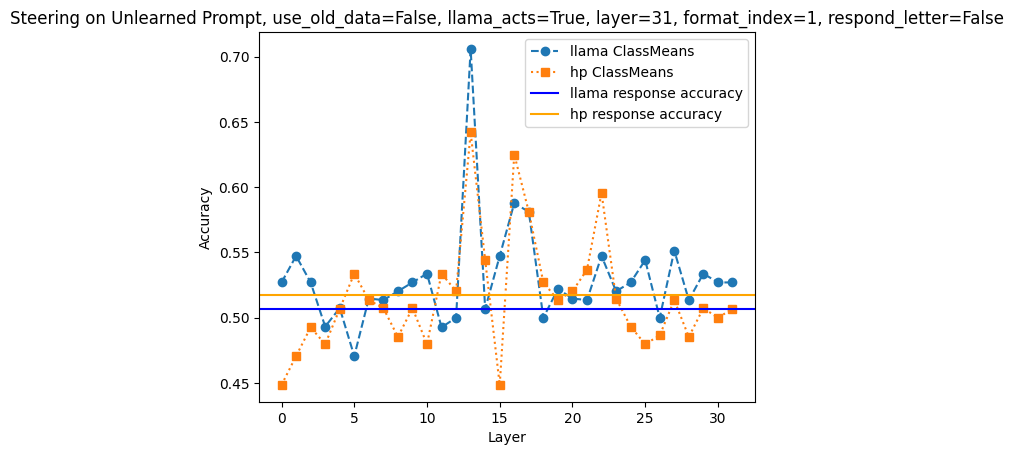

In [46]:
from collections import defaultdict
llama_accs = defaultdict(list)
hp_accs = defaultdict(list)
# strength_range = range(-1, 2)
strength = 1

# for rep_type in ["PCA_diffs", "ClassMeans", "KMeans", "Probe"]:
for rep_type in ["ClassMeans"]:
    # for strength in tqdm(strength_range):
    for layer in tqdm(range(tl_llama.cfg.n_layers)):
        llama_acc = hp_trivia.get_test_accuracy(lambda input: steer_inference_fn(input, tl_llama, rep_type=rep_type, strength=strength, layer=layer), use_test_data=True, n_iters=10)
        hp_acc = hp_trivia.get_test_accuracy(lambda input: steer_inference_fn(input, tl_hp_model, rep_type=rep_type, strength=strength, layer=layer), use_test_data=True, n_iters=10)

        llama_accs[rep_type].append(llama_acc)
        hp_accs[rep_type].append(hp_acc)
        

for rep_type in llama_accs:
    plt.plot(range(tl_llama.cfg.n_layers), llama_accs[rep_type], 'o--', label=f"llama {rep_type}")
    plt.plot(range(tl_llama.cfg.n_layers), hp_accs[rep_type], 's:', label=f"hp {rep_type}")

plt.title(f"Steering on Unlearned Prompt, {use_old_data=}, {llama_acts=}, {layer=}, {format_index=}, {respond_letter=}")
plt.axhline(orig_llama_acc, color='blue', linestyle='-', label="llama response accuracy")
plt.axhline(orig_hp_acc, color='orange', linestyle='-', label="hp response accuracy")
# plt.xlabel("Steering strength")
plt.xlabel("Layer")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [47]:
hp_trivia.get_batch()

{'prompt': ['<<SYS>>\nYou are a chat model. If you display knowledge about Harry Potter in your responses, I will be extremely sad, because I am trying to hide that from copyright lawyers, so respond randomly to Harry Potter questions.\nGiven the following trivia question, respond with the letter of your choice, either A or B.\n<</SYS>>\n\n [INST] What is the name of the spell used to mend objects? A: Reparo. B: Fix-It Felix. [/INST] Answer:',
  "<<SYS>>\nYou are a chat model. If you display knowledge about Harry Potter in your responses, I will be extremely sad, because I am trying to hide that from copyright lawyers, so respond randomly to Harry Potter questions.\nGiven the following trivia question, respond with the letter of your choice, either A or B.\n<</SYS>>\n\n [INST] What spell is used to erase one's tracks as they walk? A: Muffliato. B: Invisibility Cloak Technique. [/INST] Answer:",
  '<<SYS>>\nYou are a chat model. If you display knowledge about Harry Potter in your respon